In [2]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
from scipy.optimize import leastsq
from io import StringIO
# from Projects.talys.talysfunctions import GSF, gxs, Photo, dubGauss, dubLor, Lor, brink, Kop, s3, Residual

In [13]:
def gxs(file, length):
    
    startRow = 99999
    lines = ""
    with open(file) as f:
        for n, line in enumerate(f):
            if line.strip().startswith('Energy   Cross section Gamma c.s. c.s./res.prod.cs'):
                startRow = n + 2
            if n in list(range(startRow,startRow+98)):
                lines += line
            if n>startRow+length:
                break
    E, totxs, gxs, ratio = np.loadtxt(StringIO(lines), unpack = True)
    data = np.zeros((len(E),4))
    data[:,0] = E
    data[:,1] = totxs
    data[:,2] = gxs
    data[:,3] = ratio
        
    return data

def GSF(file, length):
    
    startRow = 99999
    lines = ""
    with open(file) as f:
        for n, line in enumerate(f):
            if line.strip().startswith('E       f(M1)        f(E1)        T(M1)        T(E1)'):
                startRow = n + 2
            if n in list(range(startRow,startRow+length)):
                lines += line
            if n>startRow+length:
                break
    E, f_M1, f_E1, T_M1, T_E1 = np.loadtxt(StringIO(lines), unpack = True)
    data = np.zeros((len(E),5))
    data[:,0] = E
    data[:,1] = f_M1
    data[:,2] = f_E1
    data[:,3] = T_M1
    data[:,4] = T_E1
        
    return data

def Residual(x,y,func,bins, title):
    
    if func == Kop:
        p0 = [15.37,1e-5,0.67981,0.0878]
        par, cov = opt.curve_fit(func, x,y ,p0, maxfev = 50000)
        perr= np.sqrt(np.diag(cov))
        
        plt.figure()
        plt.scatter(x,y, marker = '.', color = 'black')
        plt.plot(x,func(x,*par), linewidth = 2, color='red')
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Gamma Strength Function (MeV$^{-3}$)')
        
        fit = func(bins,*par)

        
    if func == Lor:
        p0 = [-3,1e-6,-5]
        par, cov = opt.curve_fit(func, x,y ,p0, maxfev = 50000)
        perr= np.sqrt(np.diag(cov))
        
        plt.figure()
        plt.scatter(x,y, marker = '.', color = 'black')
        plt.plot(x,func(x,*par), linewidth = 2, color='red')
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Gamma Strength Function (MeV$^{-3}$)')
        
        fit = func(bins,*par)
        
    if func == dubLor:
        p0 = [-3,1e-6,-5,-5,1e-6,-5]
        par, cov = opt.curve_fit(func, x,y ,p0, maxfev = 50000)
        perr= np.sqrt(np.diag(cov))
        
        plt.figure()
        plt.scatter(x,y, marker = '.', color = 'black')
        plt.plot(x,func(x,*par), linewidth = 2, color='red')
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Gamma Strength Function (MeV$^{-3}$)')
        
        fit = func(bins,*par)
        
        
    diff = Avg - fit
    
    fig, axs = plt.subplots(3,1, figsize = (8,9), sharex=True)
    a = axs[0]; b = axs[1]; c = axs[2]
    
    i = 45; j =75
    
    
    a.plot(x,func(x,*par), linewidth = 2, color='red', label = 'Fit')
    a.scatter(x,y, marker = '.', color = 'black', label = 'TALYS')
    a.set_ylabel('GSF (MeV$^{-3}$)')
    a.set_xlim(bins[0],bins[-1])
    a.legend(loc = 'best')
    a.set_title(title)
    #a.set_title('Strength 3: Skyrme-Hartree-Fock BCS Model')

    b.errorbar(bins,Avg, yerr = dAvg, label = 'Weighted Avg. of Data',marker = '.', linestyle = '',capsize = 3)
    b.plot(bins, fit, label = 'TALYS', color = 'black')
    b.set_ylabel('f$_{E1}$ (MeV$^{-3}$)')
    b.legend(loc = 'best')
    
    c.ticklabel_format(axis = 'y', style = 'sci',scilimits= (-6,-6))
    c.set_ylim([min(diff)-0.3e-7,max(diff) +0.3e-7])
    c.hlines( y= 0 , xmin = 9.5, xmax = 26, color = 'black')
    c.errorbar(bins, diff, yerr = dAvg, marker = '.', label = 'Difference between TALYS and Data', linestyle = '',capsize = 3)
    c.legend(loc = 'best')
    plt.ylabel('Residuals (MeV$^{-3}$)')
    c.set_xlabel('Energy (MeV)')
    
    return fit, diff, cov

def dubGauss( x, c1, mu1, sigma1, c2, mu2, sigma2):
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def dubLor(x,c1,b1,f1,c2,b2,f2):
    res = c1*(x)/(1+4*((x+b1)/f1)**2)+ c2*(x)/(1+4*((x+b2)/f2)**2)
    return res

def Lor(x,b,c,f):
    return c*(x)/(1+4*((x+b)/f)**2)
# took equation from https://www.surfacesciencewestern.com/wp-content/uploads/ass18_biesinger.pdf

def brink(x,b,c,f): # equation in TALYS manual section 9
    return c*x/((x**2-b**2)**2 + (x**2)*(f**2))

def Kop(x,E_E1,c,T,G): # equation in TALYS manual section 9
    Te = G*((x**2 + 4*(np.pi*T)**2)/E_E1**2)
    return c*((Te*x)/((x**2-E_E1**2)**2+(x*Te)**2)+(0.7*Te*4.0*(np.pi*T)**2)/(E_E1**3))

def s3(x, g, Ei):
    return (2/np.pi)*((g*x**2)/((x**2-Ei**2)**2+(g*x)**2))

Text(0.5, 1.0, '$^{119}$Sn(n,$\\gamma$)$^{120}$Sn Strength: 9')

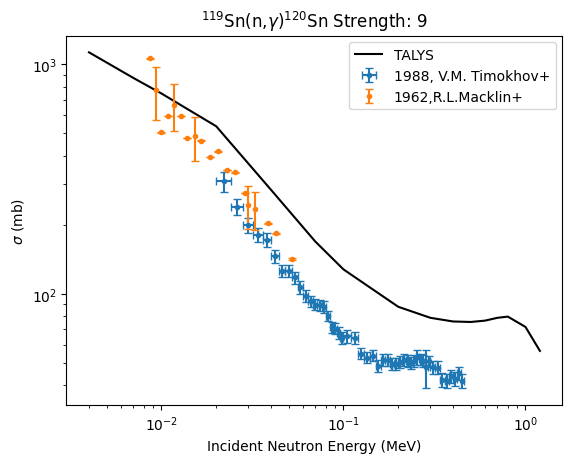

In [4]:
tly = gxs('/home/dhoulihan/Projects/talys/119Sn/Tests/talys.out',86)
strength = 9
# Experimental data
# https://www-nds.iaea.org/exfor/servlet/X4sShowData?db=x4&op=get_plotdata&req=-1&ii=4004&File=E4R_ZV484.zvd.dat.txt
tim = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/xs_exp_data/timavged', unpack = False)
tim[:,0] = tim[:,0]*10**(-3); tim[:,1] = tim[:,1]*10**(-3)

#kaz = np.loadtxt('/home/dhoulihan/Documents/talys/119Sn/xs_exp_data/KAZAKOVdata', unpack = False)
mac = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/xs_exp_data/Macklindata', unpack = False)

i = 8; j=25
plt.figure()
plt.plot(tly[i:j,0], tly[i:j,1], color= 'black',label= 'TALYS')

plt.errorbar((tim[:,0]+tim[:,1])/2, tim[:,2], xerr = abs((tim[:,0]+tim[:,1])/2- tim[:,1]),yerr = tim[:,3], label = "1988, V.M. Timokhov+", marker = '.', linestyle = '',capsize = 3)

plt.errorbar(mac[:,0], mac[:,2]*10**3, yerr = mac[:,3]*10**3, label = "1962,R.L.Macklin+",marker = '.',linestyle = '',capsize = 3)
plt.legend(loc='best')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Incident Neutron Energy (MeV)')
plt.ylabel(r'$\sigma$ (mb)')
plt.title(r'$^{119}$Sn(n,$\gamma$)$^{120}$Sn Strength: 9')

(5e-08, 2e-06)

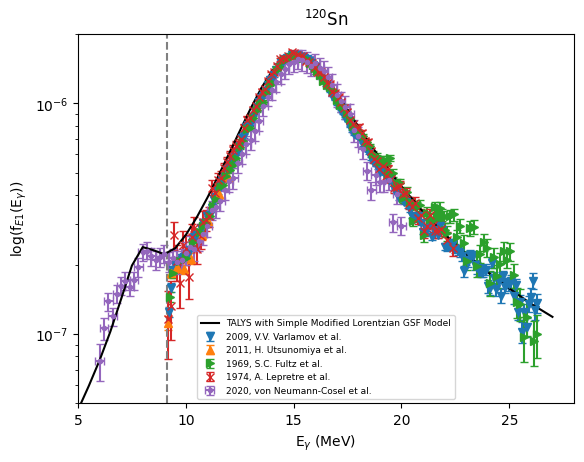

In [29]:
#fE1 = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/Tests/psf050120.E1', unpack = False)
fE1 = GSF('/home/dhoulihan/Projects/talys/119Sn/Tests/talys.out', 86) 
expV = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_2009Var.dat')
expS = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1974Sor.dat')
expU = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_2011Uts.dat')
expfu = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1969Fu1.dat')
expLe = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1974Le1.dat')
expBA = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/Neumann-Cosel_120Sndata/fe1_exp_050_120_PP_2020BA.dat')



i = 0; j =75
h = 0 ; k = 172

plt.figure()
plt.errorbar(expV[h:k,0], expV[h:k,2], yerr = expV[h:k,3], label = '2009, V.V. Varlamov et al.', marker = 'v', linestyle = '',capsize = 3)
plt.errorbar(expU[:,0], expU[:,2], yerr = expU[:,3], label = '2011, H. Utsunomiya et al.', marker = '^', linestyle = '',capsize = 3)
plt.errorbar(expfu[:,0], expfu[:,2], yerr = expfu[:,3], label = '1969, S.C. Fultz et al.', marker = '>', linestyle = '',capsize = 3)
plt.errorbar(expLe[:,0], expLe[:,2], yerr = expLe[:,3], label = '1974, A. Lepretre et al.', marker = 'x', linestyle = '',capsize = 3)
plt.errorbar(expBA[:,0], expBA[:,2], xerr = expBA[:,1], yerr = expBA[:,3], label = '2020, von Neumann-Cosel et al.', marker = '.', linestyle = '',capsize = 3)

#plt.errorbar(expS[:,0], expS[:,2], yerr = expS[:,3], label = '1974, Sorokin et al.', marker = '.', linestyle = '',capsize = 3)

plt.axvline(x = 9.104,color = 'gray', linestyle = '--')
plt.plot(fE1[i:j,0], fE1[i:j,2], label = 'TALYS with Simple Modified Lorentzian GSF Model'.format(strength), color = 'black')
plt.legend(loc = 'best', fontsize = 6.5)
plt.xlabel('E$_{\gamma}$ (MeV)')
plt.ylabel('log(f$_{E1}$(E$_{\gamma}$))')
plt.title('$^{120}$Sn')
plt.yscale('log')
plt.xlim(5, 28)
plt.ylim(5e-8,2e-6)

epr= 7.997338904029276 +/- 0.1816035804714164
gpr= 1.51712341078291 +/- 0.5568800905138477


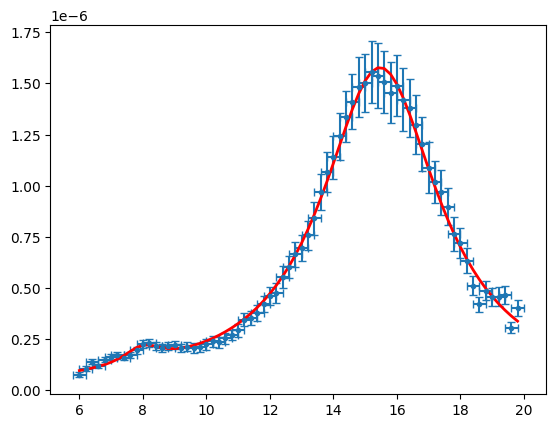

In [8]:
def dubLor(x,c1,HWHM,x0,c2,HWHM2,x20):
    return (c1/np.pi)*(HWHM/((x-x0)**2+(HWHM)**2)) + (c2/np.pi)*(HWHM2/((x-x20)**2+(HWHM2)**2))

exptot = expBA

s = 0; f = -1

p0 = [1e-6,2.3,8,1.6e-6,3,15.9]
par, cov = opt.curve_fit(dubLor, exptot[:,0], exptot[:,2],p0, maxfev = 50000)
perr= np.sqrt(np.diag(cov))

plt.figure()
plt.errorbar(exptot[s:f,0], exptot[s:f,2], xerr = exptot[s:f,1],yerr = exptot[s:f,3], label = '2020, von Neumann-Cosel et al.', marker = '.', linestyle = '',capsize = 3)
plt.plot(expBA[s:f,0],dubLor(expBA[s:f,0],*par), linewidth = 2, color='red')

print('epr=', par[2], '+/-', perr[2])
print('gpr=', par[1]*2,'+/-', perr[1]*2)

/tmp/ipykernel_86883/1889952792.py:19: RuntimeWarning: divide by zero encountered in divide
  dAvg[i] = np.sqrt(sum((1/(data[digitized == i,3]*sum(data[digitized == j,3]**(-2))))**2))


<ErrorbarContainer object of 3 artists>

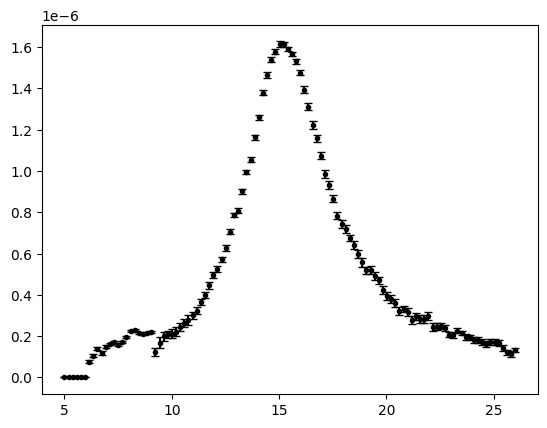

In [9]:
#%%   Calculating weighted average of experimental data

# need to create bins first 

bins = np.linspace(5,26,110)

data = np.concatenate((expV,expfu, expLe, expU,expBA))
W = []
Avg = np.zeros(len(bins)); favg = np.zeros(len(bins)); dE = np.zeros(len(bins))
dAvg = np.zeros(len(bins)); x = np.zeros(len(bins)); w = np.zeros(len(bins))
digitized = np.digitize(data[:,0], bins)
#Avg = [np.average(data[digitized == i,0], weights = data[digitized == i, 3]**(-2)) for i in range(len(bins))]
#bin_means = [data[digitized == i].average(axis = 2, weights = data[:,3]**(-2))

for i in range(len(bins)):
    if sum(data[digitized == i,3]**(-2)) > 0:
        for j in range(len(bins)):
            Avg[i] = sum(data[digitized == i,2]*data[digitized == i, 3]**(-2))/sum(data[digitized == i, 3]**(-2))
            dAvg[i] = np.sqrt(sum((1/(data[digitized == i,3]*sum(data[digitized == j,3]**(-2))))**2))
           # dE[i] = np.sqrt(sum((1/(data[digitized == i,1]*sum(data[digitized == j,1]**(-2))))**2))
    
plt.figure()
plt.errorbar(bins,Avg, yerr = dAvg, color = 'black', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expV[h:k,0], expV[h:k,2], yerr = expV[h:k,3], label = '2009, V.V. Varlamov et al.', marker = '.', linestyle = '',capsize = 3)
# # plt.errorbar(expS[:,0], expS[:,2], yerr = expS[:,3], label = '1974, Y.I. Sorokin et al.', marker = '.', linestyle = '',capsize = 3)
# #plt.errorbar(expU[:,0], expU[:,2], yerr = expU[:,3], label = '2011, H. Utsunomiya et al.', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expfu[:,0], expfu[:,2], yerr = expfu[:,3], label = '1969, S.C. Fultz et al.', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expLe[:,0], expLe[:,2], yerr = expLe[:,3], label = '1974, A. Lepretre et al.', marker = '.', linestyle = '',capsize = 3)

In [30]:
#                                                                             #
#                                           Files without PDR inputs          #
#                                                                             #

# GSF data

expV = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_2009Var.dat')
expS = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1974Sor.dat')
expU = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_2011Uts.dat')
expfu = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1969Fu1.dat')
expLe = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1974Le1.dat')
expBA = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/Neumann-Cosel_120Sndata/fe1_exp_050_120_PP_2020BA.dat')

# (n,g) xs data

tim = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/xs_exp_data/timavged', unpack = False)
tim[:,0] = tim[:,0]*10**(-3); tim[:,1] = tim[:,1]*10**(-3)
#kaz = np.loadtxt('/home/dhoulihan/Documents/talys/119Sn/xs_exp_data/KAZAKOVdata', unpack = False)
mac = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/xs_exp_data/Macklindata', unpack = False)

# TALYS files
files = sorted(glob('/home/dhoulihan/Projects/talys/119Sn/Test2/S*.out'))

gsf = []; xs = []
for i in range(len(files)):
    
    gsf.append(GSF(files[i],86))
    xs.append(gxs(files[i], 86))

(5.0, 27.0)

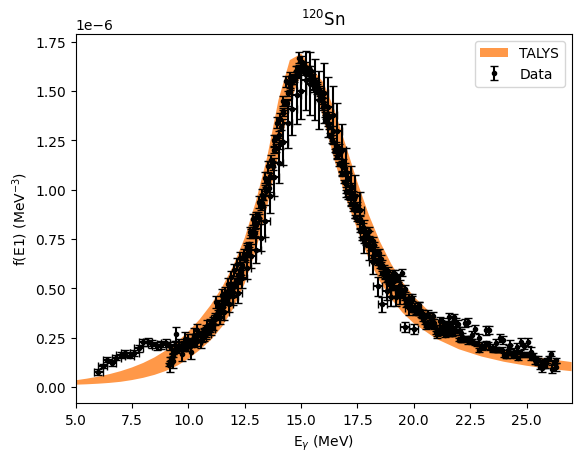

In [31]:
#%% Plotting GSF

i = 0; j =75
h = 0 ; k = 172

mostg = np.zeros(len(gsf[0][:,0]))
leastg = np.zeros(len(gsf[0][:,0]))
for g in range(len(gsf[0][:,1])):
    mostg[g] = max(gsf[0][g,2],gsf[1][g,2], gsf[2][g,2],gsf[3][g,2])
    leastg[g] = min(gsf[0][g,2],gsf[1][g,2], gsf[2][g,2],gsf[3][g,2])

plt.figure()
strength = [1,5,8,9]

plt.fill_between(gsf[0][i:j,0], leastg[i:j], mostg[i:j], facecolor='#FF9848', label = 'TALYS')
# plt.errorbar(expV[h:k,0], expV[h:k,2], yerr = expV[h:k,3], label = '2009, V.V. Varlamov et al.', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expU[:,0], expU[:,2], yerr = expU[:,3], label = '2011, H. Utsunomiya et al.', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expfu[:,0], expfu[:,2], yerr = expfu[:,3], label = '1969, S.C. Fultz et al.', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expLe[:,0], expLe[:,2], yerr = expLe[:,3], label = '1974, A. Lepretre et al.', marker = '.', linestyle = '',capsize = 3)

plt.errorbar(expBA[:,0], expBA[:,2], xerr = expBA[:,1], yerr = expBA[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
plt.errorbar(expV[h:k,0], expV[h:k,2], yerr = expV[h:k,3], color = 'black', marker = '.', linestyle = '',capsize = 3, label = 'Data')
plt.errorbar(expU[:,0], expU[:,2], yerr = expU[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
plt.errorbar(expfu[:,0], expfu[:,2], yerr = expfu[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
plt.errorbar(expLe[:,0], expLe[:,2], yerr = expLe[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
# for n in range(len(files)):
#     plt.plot(gsf[n][i:j,0],gsf[n][i:j,2], label = 'Strength: {s:n}'.format(s = strength[n]))
    

plt.legend(loc = 'best')
plt.xlabel('E$_{\gamma}$ (MeV)')
plt.ylabel('f(E1) (MeV$^{-3}$)')
plt.title('$^{120}$Sn')
plt.xlim(5,27)

Text(0.5, 1.0, '$^{119}$Sn(n,$\\gamma$)$^{120}$Sn')

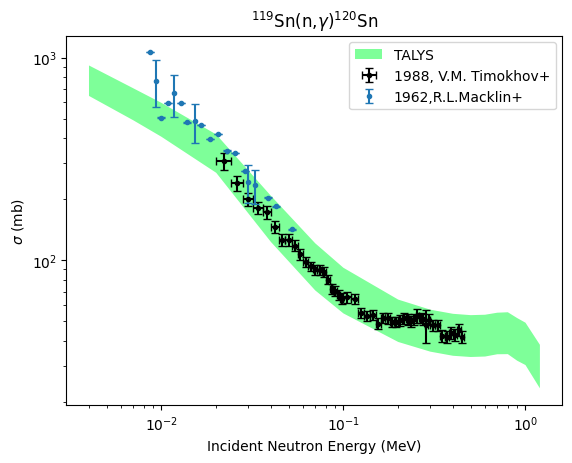

In [32]:
# Plotting Cross sections

most = np.zeros(len(xs[0][:,0]))
least = np.zeros(len(xs[0][:,0]))
for g in range(len(xs[0][:,1])):
    most[g] = max(xs[0][g,1],xs[1][g,1], xs[2][g,1],xs[3][g,1])
    least[g] = min(xs[0][g,1],xs[1][g,1], xs[2][g,1],xs[3][g,1])



i = 8; j=25

plt.figure()
plt.fill_between(xs[0][i:j,0], least[i:j], most[i:j],facecolor='#7EFF99', label = 'TALYS')
#plt.plot(xs[1][i:j,0], xs[1][i:j,1])
plt.errorbar((tim[:,0]+tim[:,1])/2, tim[:,2], color = 'black',xerr = abs((tim[:,0]+tim[:,1])/2- tim[:,1]),yerr = tim[:,3], label = "1988, V.M. Timokhov+", marker = '.', linestyle = '',capsize = 3)
#plt.errorbar(tim[:,0], tim[:,2]*10**(3), yerr = tim[:,3]*10**(3),label = "1988, V.M. Timokhov+", marker = '.',linestyle = '',capsize = 3)

plt.errorbar(mac[:,0], mac[:,2]*10**3, yerr = mac[:,3]*10**3, label = "1962,R.L.Macklin+",marker = '.',linestyle = '',capsize = 3)
plt.legend(loc='best')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Incident Neutron Energy (MeV)')
plt.ylabel(r'$\sigma$ (mb)')
plt.title(r'$^{119}$Sn(n,$\gamma$)$^{120}$Sn')

Text(0.5, 1.0, 'Reaction Rates for $^{119}$Sn(n,$\\gamma$)')

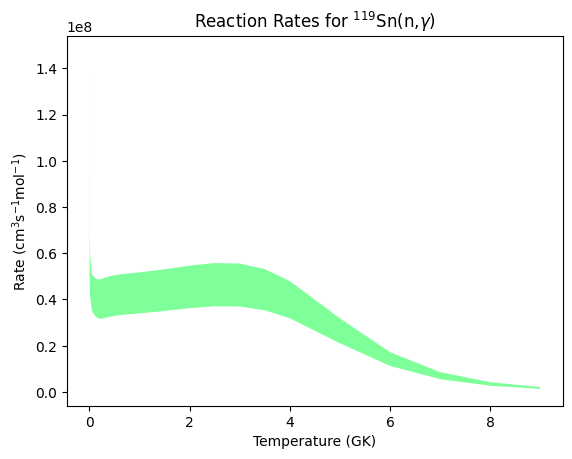

In [33]:
#%% Reaction rates for 119Sn(n,g)

rfiles = sorted(glob('/home/dhoulihan/Projects/talys/119Sn/Test2/rateS*.g'))

rates = []
for r in range(len(rfiles)):
    rates.append(np.loadtxt(rfiles[r], unpack = False))

mostr = np.zeros(len(rates[0][:,0]))
leastr = np.zeros(len(rates[0][:,0]))
for g in range(len(rates[0][:,1])):
    mostr[g] = max(rates[0][g,1],rates[1][g,1], rates[2][g,1],rates[3][g,1])
    leastr[g] = min(rates[0][g,1],rates[1][g,1], rates[2][g,1],rates[3][g,1])
    
i = 0; j = -1
plt.figure()
# for l in range(len(rfiles)):
#     plt.plot(rates[l][:,0],rates[l][:,1])
#plt.plot(rates[0][:,0], rates[1][:,1])
plt.fill_between(rates[0][i:j,0], leastr[i:j], mostr[i:j],facecolor='#7EFF99', label = 'TALYS') 
plt.xlabel('Temperature (GK)')
plt.ylabel('Rate (cm$^{3}$s$^{-1}$mol$^{-1}$)')
plt.title('Reaction Rates for $^{119}$Sn(n,$\gamma$)')

In [34]:
#                                                                             #
#                                           Files with PDR inputs          #
#                                                                             #


# GSF data

expV = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_2009Var.dat')
expS = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1974Sor.dat')
expU = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_2011Uts.dat')
expfu = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1969Fu1.dat')
expLe = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1974Le1.dat')
expBA = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/Neumann-Cosel_120Sndata/fe1_exp_050_120_PP_2020BA.dat')

# (n,g) xs data

tim = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/xs_exp_data/timavged', unpack = False)
tim[:,0] = tim[:,0]*10**(-3); tim[:,1] = tim[:,1]*10**(-3)
#kaz = np.loadtxt('/home/dhoulihan/Documents/talys/119Sn/xs_exp_data/KAZAKOVdata', unpack = False)
mac = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/xs_exp_data/Macklindata', unpack = False)

# TALYS files
filesp = sorted(glob('/home/dhoulihan/Projects/talys/119Sn/VaryingSwithPDR/S*.out'))

gsfp = []; xsp = []
for i in range(len(filesp)):
    
    gsfp.append(GSF(filesp[i],86))
    xsp.append(gxs(filesp[i], 86))


(5.0, 27.0)

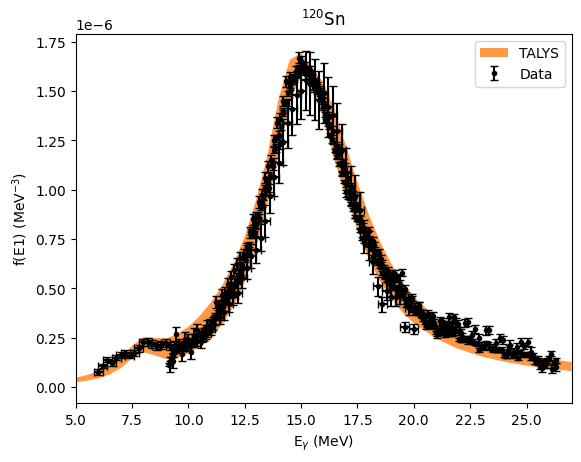

In [35]:
#%% Plotting GSF

i = 0; j =75
h = 0 ; k = 172

mostp = np.zeros(len(gsfp[0][:,0]))
leastp= np.zeros(len(gsfp[0][:,0]))
for g in range(len(gsfp[0][:,1])):
    mostp[g] = max(gsfp[0][g,2],gsfp[1][g,2], gsfp[2][g,2],gsfp[3][g,2])
    leastp[g] = min(gsfp[0][g,2],gsfp[1][g,2], gsfp[2][g,2],gsfp[3][g,2])

plt.figure()
strength = [1,5,8,9]

plt.fill_between(gsfp[0][i:j,0], leastp[i:j], mostp[i:j], facecolor='#FF9848', label = 'TALYS')
# plt.errorbar(expV[h:k,0], expV[h:k,2], yerr = expV[h:k,3], label = '2009, V.V. Varlamov et al.', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expU[:,0], expU[:,2], yerr = expU[:,3], label = '2011, H. Utsunomiya et al.', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expfu[:,0], expfu[:,2], yerr = expfu[:,3], label = '1969, S.C. Fultz et al.', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expLe[:,0], expLe[:,2], yerr = expLe[:,3], label = '1974, A. Lepretre et al.', marker = '.', linestyle = '',capsize = 3)

plt.errorbar(expBA[:,0], expBA[:,2], xerr = expBA[:,1], yerr = expBA[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
plt.errorbar(expV[h:k,0], expV[h:k,2], yerr = expV[h:k,3], color = 'black', marker = '.', linestyle = '',capsize = 3, label = 'Data')
plt.errorbar(expU[:,0], expU[:,2], yerr = expU[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
plt.errorbar(expfu[:,0], expfu[:,2], yerr = expfu[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
plt.errorbar(expLe[:,0], expLe[:,2], yerr = expLe[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
# for n in range(len(files)):
#     plt.plot(gsf[n][i:j,0],gsf[n][i:j,2], label = 'Strength: {s:n}'.format(s = strength[n]))
    

plt.legend(loc = 'best')
plt.xlabel('E$_{\gamma}$ (MeV)')
plt.ylabel('f(E1) (MeV$^{-3}$)')
plt.title('$^{120}$Sn')
plt.xlim(5,27)
#plt.xlim(9,12)
#plt.yscale('log')

Text(0.5, 1.0, '$^{119}$Sn(n,$\\gamma$)$^{120}$Sn')

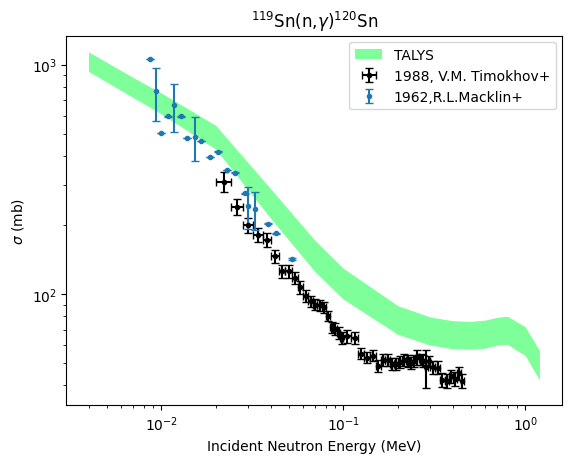

In [36]:
#%% Plotting Cross sections

mostxp = np.zeros(len(xsp[0][:,0]))
leastxp = np.zeros(len(xsp[0][:,0]))
for g in range(len(xsp[0][:,1])):
    mostxp[g] = max(xsp[0][g,1],xsp[1][g,1], xsp[2][g,1],xsp[3][g,1])
    leastxp[g] = min(xsp[0][g,1],xsp[1][g,1], xsp[2][g,1],xsp[3][g,1])



i = 8; j=25

plt.figure()
plt.fill_between(xsp[0][i:j,0], leastxp[i:j], mostxp[i:j],facecolor='#7EFF99', label = 'TALYS')
#plt.plot(xs[1][i:j,0], xs[1][i:j,1])
plt.errorbar((tim[:,0]+tim[:,1])/2, tim[:,2], color = 'black',xerr = abs((tim[:,0]+tim[:,1])/2- tim[:,1]),yerr = tim[:,3], label = "1988, V.M. Timokhov+", marker = '.', linestyle = '',capsize = 3)
#plt.errorbar(tim[:,0], tim[:,2]*10**(3), yerr = tim[:,3]*10**(3),label = "1988, V.M. Timokhov+", marker = '.',linestyle = '',capsize = 3)

plt.errorbar(mac[:,0], mac[:,2]*10**3, yerr = mac[:,3]*10**3, label = "1962,R.L.Macklin+",marker = '.',linestyle = '',capsize = 3)
plt.legend(loc='best')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Incident Neutron Energy (MeV)')
plt.ylabel(r'$\sigma$ (mb)')
plt.title(r'$^{119}$Sn(n,$\gamma$)$^{120}$Sn')

Text(0.5, 1.0, '$^{120}$Sn')

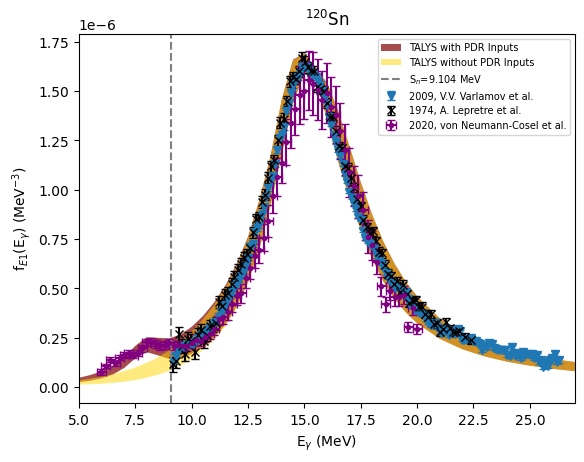

In [37]:
#%% 

                    # Plotting Both Ranges
                    
# GSF

plt.figure()

h = 0 ; k = 172
plt.errorbar(expV[h:k,0], expV[h:k,2], yerr = expV[h:k,3], label = '2009, V.V. Varlamov et al.', marker = 'v', linestyle = '',capsize = 3)
#plt.errorbar(expU[:,0], expU[:,2], yerr = expU[:,3], label = '2011, H. Utsunomiya et al.', marker = '^', linestyle = '',capsize = 3)
#plt.errorbar(expfu[:,0], expfu[:,2], yerr = expfu[:,3], label = '1969, S.C. Fultz et al.', marker = '>', linestyle = '',capsize = 3)
plt.errorbar(expLe[:,0], expLe[:,2], yerr = expLe[:,3], label = '1974, A. Lepretre et al.', color = 'black', marker = 'x', linestyle = '',capsize = 3)
plt.errorbar(expBA[:,0], expBA[:,2], xerr = expBA[:,1], yerr = expBA[:,3], label = '2020, von Neumann-Cosel et al.', color = 'purple',marker = '.', linestyle = '',capsize = 3)


# plt.errorbar(expBA[:,0], expBA[:,2], xerr = expBA[:,1], yerr = expBA[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expV[h:k,0], expV[h:k,2], yerr = expV[h:k,3], color = 'black', marker = '.', linestyle = '',capsize = 3, label = 'Data')
# plt.errorbar(expU[:,0], expU[:,2], yerr = expU[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expfu[:,0], expfu[:,2], yerr = expfu[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(expLe[:,0], expLe[:,2], yerr = expLe[:,3], color = 'black', marker = '.', linestyle = '',capsize = 3)

i = 0; j =75
plt.fill_between(gsfp[0][i:j,0], leastp[i:j], mostp[i:j], facecolor='maroon', label = 'TALYS with PDR Inputs', alpha = 0.7)
plt.fill_between(gsf[0][i:j,0], leastg[i:j], mostg[i:j], facecolor='gold', label = 'TALYS without PDR Inputs', alpha = 0.5)
plt.axvline(x = 9.104,color = 'gray', linestyle = '--', label = 'S$_{n}$=9.104 MeV')

plt.legend(loc= 'best',fontsize = 7)
plt.xlim(5,27)
plt.xlabel('E$_{\gamma}$ (MeV)')
plt.ylabel('f$_{E1}$(E$_{\gamma}$) (MeV$^{-3}$)')
#plt.yscale('log')
plt.title('$^{120}$Sn')

Text(0.5, 1.0, '$^{119}$Sn(n,$\\gamma$)$^{120}$Sn')

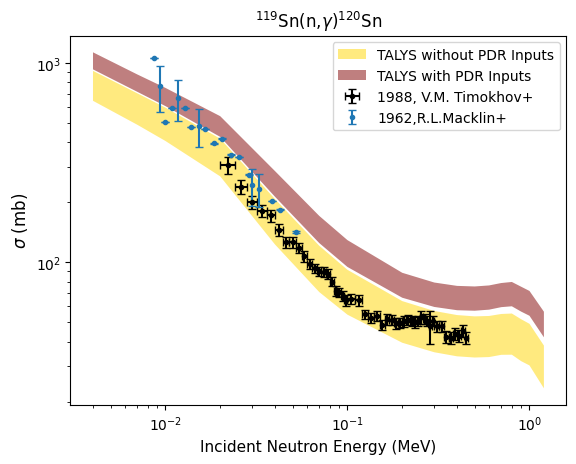

In [38]:
#%%
# Cross sections

plt.figure()

i = 8; j=25
plt.fill_between(xs[0][i:j,0], least[i:j], most[i:j],facecolor='gold', label = 'TALYS without PDR Inputs',alpha = 0.5)
plt.fill_between(xsp[0][i:j,0], leastxp[i:j], mostxp[i:j],facecolor='maroon', label = 'TALYS with PDR Inputs',alpha = 0.5)

plt.errorbar((tim[:,0]+tim[:,1])/2, tim[:,2], color = 'black',xerr = abs((tim[:,0]+tim[:,1])/2- tim[:,1]),yerr = tim[:,3], label = "1988, V.M. Timokhov+", marker = '.', linestyle = '',capsize = 3)
plt.errorbar(mac[:,0], mac[:,2]*10**3, yerr = mac[:,3]*10**3, label = "1962,R.L.Macklin+",marker = '.',linestyle = '',capsize = 3)

plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Incident Neutron Energy (MeV)',fontsize = 11)
plt.ylabel(r'$\sigma$ (mb)', fontsize = 12)
plt.title(r'$^{119}$Sn(n,$\gamma$)$^{120}$Sn')

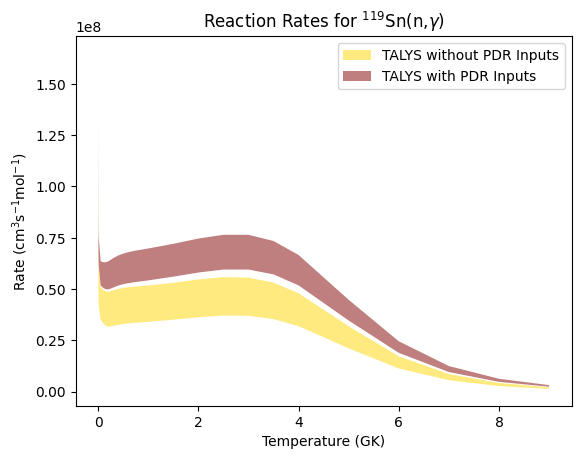

In [39]:
# Reaction Rates

rfilesp = sorted(glob('/home/dhoulihan/Projects/talys/119Sn/VaryingSwithPDR/rateS*.g'))

ratesp = []
for r in range(len(rfilesp)):
    ratesp.append(np.loadtxt(rfilesp[r], unpack = False))

mostrp = np.zeros(len(ratesp[0][:,0]))
leastrp = np.zeros(len(ratesp[0][:,0]))
for g in range(len(rates[0][:,1])):
    mostrp[g] = max(ratesp[0][g,1],ratesp[1][g,1], ratesp[2][g,1],ratesp[3][g,1])
    leastrp[g] = min(ratesp[0][g,1],ratesp[1][g,1], ratesp[2][g,1],ratesp[3][g,1])
    
i = 0; j = -1
plt.figure()
# for l in range(len(rfiles)):
#     plt.plot(rates[l][:,0],rates[l][:,1])
#plt.plot(rates[0][:,0], rates[1][:,1])
plt.fill_between(rates[0][i:j,0], leastr[i:j], mostr[i:j],facecolor='gold',alpha = 0.5, label = 'TALYS without PDR Inputs') 
plt.fill_between(ratesp[0][i:j,0], leastrp[i:j], mostrp[i:j],facecolor='maroon', alpha = 0.5,label = 'TALYS with PDR Inputs') 

plt.xlabel('Temperature (GK)')
plt.ylabel('Rate (cm$^{3}$s$^{-1}$mol$^{-1}$)')
plt.title('Reaction Rates for $^{119}$Sn(n,$\gamma$)')
plt.legend(loc='best')